# Guided Project: Answering Buiness Questions using SQL

In [1]:
# import relevant libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# create funciton to take SQL query and return pd.datarframe
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
# create function to execute command with SQL
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
# create function to return list of all tables and views in db
def show_tables():
    q = '''SELECT
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table","view");'''
    df = run_query(q)
    return df
    
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [3]:
q1 = '''
WITH
    track_genre AS 
        (
        SELECT
            t.track_id,
            g.genre_id,
            g.name
        FROM track t
        LEFT JOIN genre g ON g.genre_id = t.genre_id
        ),
        
    customer_usa AS
        (
        SELECT 
            customer_id,
            country
        FROM customer
        WHERE country = 'USA'
        ),
        
    invoice_usa AS
        (
        SELECT
            il.invoice_line_id,
            il.track_id,
            cu.country
        FROM invoice_line il
        LEFT JOIN invoice i ON i.invoice_id = il.invoice_id
        INNER JOIN customer_usa cu ON cu.customer_id = i.customer_id
        ),
        
    final AS
        (
        SELECT
            tg.name,
            tg.genre_id
        FROM track_genre tg
        INNER JOIN invoice_usa iu ON iu.track_id = tg.track_id
        )
        
SELECT
    name genre,
    COUNT(genre_id) total_count,
    ROUND(CAST(COUNT(genre_id) AS FLOAT) / 1051 * 100, 3) total_pct
FROM final
GROUP BY 1'''
run_query(q1)

,genre,total_count,total_pct
0,Alternative,35,3.330
1,Alternative & Punk,130,12.369
2,Blues,36,3.425
3,Classical,4,0.381
4,Easy Listening,13,1.237
5,Electronica/Dance,5,0.476
6,Heavy Metal,3,0.285
7,Hip Hop/Rap,20,1.903
8,Jazz,14,1.332
9,Latin,22,2.093


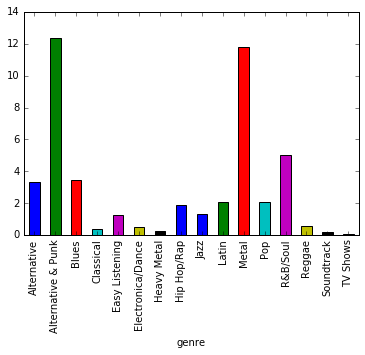

In [4]:
usa_sales_genre_breakdown = run_query(q1)
us_sales_not_rock = usa_sales_genre_breakdown.drop(14)
us_sales_not_rock.set_index('genre', drop=True, inplace=True)
us_sales_not_rock['total_pct'].plot(kind='bar')

By excluding the Rock genre from our US sales data (Rock was by far the leading genre with 53.4% of sales), we can more clearly see the breakdown of music sales by genre. Of the four albums from which we have to choose 3, we should certainly chose the Punk album Red Tone and the Blues album Slim Jim Bites. Hip-Hop and Pop songs were nearly level in number of US sales, with Pop barely outselling Hip-Hop. Thus we suggest choosing the Pop album Meteor and the Girls to sell.

In [5]:
q2 = '''
WITH
    invoice_total AS
        (
        SELECT
            c.customer_id,
            c.support_rep_id,
            il.invoice_id,
            il.unit_price * il.quantity invoice_line_total
            FROM invoice_line il
            LEFT JOIN invoice i ON i.invoice_id = il.invoice_id
            LEFT JOIN customer c ON c.customer_id = i.customer_id
            )
            
SELECT
    e.first_name || ' ' || e.last_name employee_name,
    SUM(it.invoice_line_total) total_sales,
    e.city,
    e.state,
    e.country
FROM invoice_total it
LEFT JOIN employee e ON e.employee_id = it.support_rep_id
GROUP BY 1 ORDER BY 2;
'''
run_query(q2)

,employee_name,total_sales,city,state,country
0,Steve Johnson,1393.92,Calgary,AB,Canada
1,Margaret Park,1584.00,Calgary,AB,Canada
2,Jane Peacock,1731.51,Calgary,AB,Canada


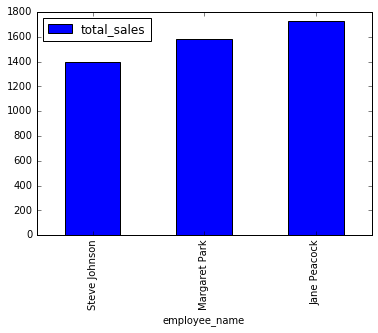

In [6]:
employee_sales = run_query(q2)
employee_sales.set_index('employee_name', drop=True, inplace=True)
employee_sales.plot(kind='bar')

The sales figures for the three Sales Support Reps range from ~$1400-1730. Due to the small number of reps and the little information given about each of them, determining a cause of the differences would be very speculative.

In [7]:
q3 = '''
WITH
    all_invoices AS
        (
        SELECT
            c.customer_id,
            i.total,
            c.country
        FROM invoice i
        LEFT JOIN customer c ON c.customer_id = i.customer_id
        ),
        
    avg_order_country AS
        (
        SELECT
            AVG(total) avg_order_value,
            country
        FROM all_invoices
        GROUP BY 2
        ),
        
    customer_sales AS
        (
        SELECT
            SUM(total) customer_total,
            country
        FROM all_invoices
        GROUP BY customer_id
        )
        
SELECT
    cs.country,
    SUM(cs.customer_total) total_sales,
    COUNT(*) total_customers,
    ROUND(SUM(cs.customer_total) / COUNT(*), 2) avg_sales_per_customer,
    ROUND(ao.avg_order_value, 2) avg_order_value
FROM customer_sales cs
INNER JOIN avg_order_country ao ON ao.country = cs.country
GROUP BY 1
ORDER BY 3 DESC;
'''

run_query(q3)

,country,total_sales,total_customers,avg_sales_per_customer,avg_order_value
0,USA,1040.49,13,80.04,7.94
1,Canada,535.59,8,66.95,7.05
2,Brazil,427.68,5,85.54,7.01
3,France,389.07,5,77.81,7.78
4,Germany,334.62,4,83.66,8.16
5,United Kingdom,245.52,3,81.84,8.77
6,Czech Republic,273.24,2,136.62,9.11
7,India,183.15,2,91.57,8.72
8,Portugal,185.13,2,92.56,6.38
9,Argentina,39.60,1,39.60,7.92


In [17]:
country_sales = run_query(q3)
country_sales.set_index('country', drop=True, inplace=True)

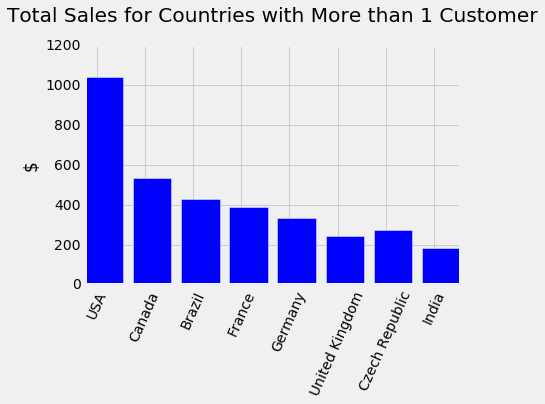

In [73]:
import numpy as np
big_countries = country_sales[:8]
x = np.arange(len(big_countries))
fig, ax = plt.subplots()
plt.style.use('fivethirtyeight')
plt.xticks(x+.25, big_countries.index.values, rotation=66)
ax.bar(x, big_countries['total_sales'])
plt.title('Total Sales for Countries with More than 1 Customer', y=1.08, )
plt.ylabel('$')
              

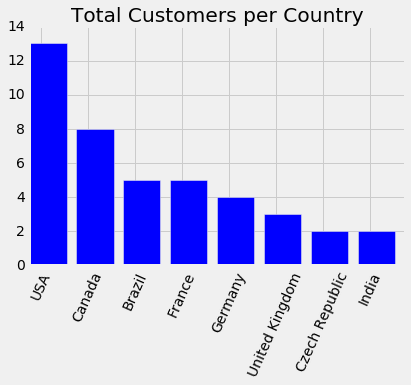

In [46]:
plt.bar(x, big_countries['total_customers'])
plt.xticks(x + .25, big_countries.index.values, rotation=66)
plt.title('Total Customers per Country')

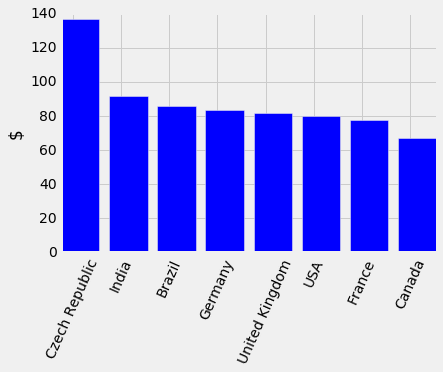

In [71]:
big_countries_avg_sales = big_countries.sort_values('avg_sales_per_customer', ascending=False)
fig = plt.subplot()
plt.xticks(x+.25, big_countries_avg_sales.index.values, rotation=66)
plt.bar(x, big_countries_avg_sales['avg_sales_per_customer'])
plt.ylabel('$')

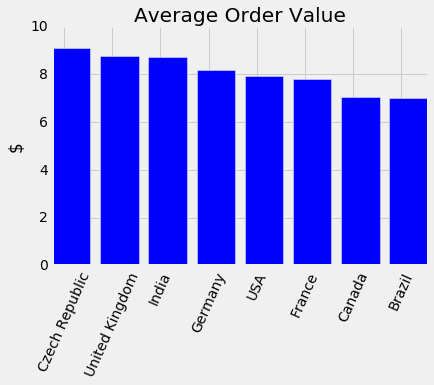

In [70]:
big_countries_avg_order = big_countries.sort_values('avg_order_value', ascending=False)
fig = plt.subplots()
plt.xticks(x+.25, big_countries_avg_order.index.values, rotation=66)
plt.bar(x, big_countries_avg_order['avg_order_value'])
plt.title('Average Order Value')
plt.ylabel('$')

Analysis of sales by country reveals a few interesting trends and opportunities for growth
-  The greatest number of sales come from the Americas and Western Europe
-  Eastern Europe and Asia (India) have the fewest customers and total sales
-  Eastern Europe and Asia have the highest revenue per customer
-  Eastern Europe and Asia have the highest average sales per order

Based on these findings, we recommend marketing efforts be directed to Eastern Europe and Asia--specifically the Czech Republic and India--where order values are relatively high and revenue per customer is highest. These markets have the lowest total number of customers, but customers generate the most revenue of any market, so growth in those areas proves attractive. 

In [97]:
q4 = '''
WITH
    invoice_first_track AS
        (
        SELECT
            invoice_id invoice_id,
            MIN(track_id) first_track_id
        FROM invoice_line
        GROUP BY 1
        )
SELECT
    album_purchased,
    COUNT(invoice_id) number_of_invoices,
    CAST(COUNT(invoice_id) AS FLOAT) / (
                                        SELECT COUNT(*) FROM invoice
                                        ) percent
FROM
    (
    SELECT
        ift.*,
        CASE
            WHEN
                (
                SELECT t.track_id FROM track t
                WHERE t.album_id = (
                                    SELECT t2.album_id from track t2
                                    WHERE t2.track_id = ift.first_track_id
                                    )
                                
                EXCEPT
            
                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ift.invoice_id
                ) IS NULL
            
            AND
        
                (
                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = ift.invoice_id
            
                EXCEPT
            
                SELECT t.track_id FROM track t
                WHERE t.album_id = (
                                    SELECT t2.album_id from track t2
                                    WHERE t2.track_id = ift.first_track_id
                                    )
                ) IS NULL
            THEN 'Yes'
            ELSE 'No'
            END AS 'album_purchased'
    FROM invoice_first_track ift
    )
GROUP BY album_purchased;
'''
run_query(q4)

,album_purchased,number_of_invoices,percent
0,No,500,0.814332
1,Yes,114,0.185668


Currently 18.6% of sales are complete album purcheses. We would not recommend purchasing single songs from albums to sell on the platform as nearly one-fifth of orders may be affected.